<a href="https://colab.research.google.com/github/AhmedZaghl0ul/Machine-Learning/blob/main/Knee_Roughness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
!pip install utils
from utils import *
from glob import glob
from itertools import chain
from datetime import datetime
import statistics
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 , DenseNet169 , DenseNet201 , ResNet50 , DenseNet121
from tensorflow.keras.layers import Dense , Conv2D , Flatten , Dropout , MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.metrics import Accuracy , Recall , AUC , BinaryAccuracy , FalsePositives , FalseNegatives
from tensorflow.keras.callbacks import CSVLogger , ModelCheckpoint , ReduceLROnPlateau , EarlyStopping
from tensorflow.keras.optimizers import Adam , SGD
from tensorflow.keras.losses import BinaryCrossentropy
from keras import backend as K

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install split-folders

In [5]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/DataSets/Knee X-ray Images"  , output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 3456 files [00:52, 66.36 files/s] 


In [6]:
img_hight = 128
img_width = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/output/train',
    seed=123,
    image_size=(img_hight, img_width),
    batch_size=32,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/output/val',
    seed=123,
    image_size=(img_hight, img_width),
    batch_size=32,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/output/test',
    seed=123,
    image_size=(img_hight, img_width),
    batch_size=32,
    shuffle=False
)

Found 2763 files belonging to 5 classes.
Found 343 files belonging to 5 classes.
Found 350 files belonging to 5 classes.


In [7]:
ytrue = np.concatenate([y for x, y in test_ds], axis=0)

In [8]:
ytrue

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [9]:
img_ind = 128
img_shape = (img_hight, img_width, 3)
batch_size = 64
Loss = BinaryCrossentropy()

In [10]:
def get_callbaks(model_name):
  callbacks = []

  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = f"model.{model_name}.h5" , verbose=1 , save_best_only=True , monitor="val_loss" , mode = "min" , )
  callbacks.append(checkpoint)
  anne = ReduceLROnPlateau(monitor="val_loss" , patience=5 , fator=0.5 , min_lr = 0.00000001 , min_delta=0.00001 , verbose=1)
  callbacks.append(anne)
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
  callbacks.append(early_stopping)

  return callbacks

In [11]:
from tensorflow.keras.applications import MobileNet

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=img_shape)

for layer in base_model.layers[200:]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=get_callbaks("Xception")
)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,233,989 (12.34 MB)

 Trainable params: 3,212,101 (12.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5863 - loss: 1.3415
Epoch 1: val_loss improved from inf to 6.31281, saving model to model.Xception.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5875 - loss: 1.3372 - val_accuracy: 0.2682 - val_loss: 6.3128 - learning_rate: 0.0010
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8556 - loss: 0.4164
Epoch 2: val_loss improved from 6.31281 to 2.77732, saving model to model.Xception.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8558 - loss: 0.4157 - val_accuracy: 0.4257 - val_loss: 2.7773 - learning_rate: 0.0010
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9120 - loss: 0.2396
Epoch 3: val_loss improved from 2.77732 to 1.36510, saving model to model.Xception.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.9121 - loss: 0.2393 - val_accuracy: 0.6735 - val_loss: 1.3651 - learning_rate: 0.0010
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9161 - loss: 0.2354
Epoch 4: val_loss did not improve from 1.36510
87/87 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9161 - loss: 0.2354 - val_accuracy: 0.4694 - val_loss: 2.9060 - learning_rate: 0.0010
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9194 - loss: 0.2284
Epoch 5: val_loss did not improve from 1.36510
87/87 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.9197 - loss: 0.2278 - val_accuracy: 0.6356 - val_loss: 1.3964 - learning_rate: 0.0010
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9454 - loss: 0.1563
Epoch 6: val_loss improved from 1.36510 to 0.52833, saving model to model.Xception.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9455 - loss: 0.1563 - val_accuracy: 0.8542 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9772 - loss: 0.0978
Epoch 7: val_loss did not improve from 0.52833
87/87 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9772 - loss: 0.0978 - val_accuracy: 0.8105 - val_loss: 0.7870 - learning_rate: 0.0010
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9662 - loss: 0.1184
Epoch 8: val_loss did not improve from 0.52833
87/87 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9663 - loss: 0.1183 - val_accuracy: 0.8047 - val_loss: 0.5672 - learning_rate: 0.0010
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9605 - loss: 0.1102
Epoch 9: val_loss improved from 0.52833 to 0.31177, saving model to model.Xception.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.9605 - loss: 0.1101 - val_accuracy: 0.9038 - val_loss: 0.3118 - learning_rate: 0.0010
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9684 - loss: 0.0879
Epoch 10: val_loss did not improve from 0.31177
87/87 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9685 - loss: 0.0878 - val_accuracy: 0.7843 - val_loss: 0.7382 - learning_rate: 0.0010


In [12]:
loss, accuracy = model.evaluate(val_ds)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - accuracy: 0.8115 - loss: 0.6286
Validation Loss: 0.7382053136825562
Validation Accuracy: 0.7842565774917603


In [14]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(ytrue, y_pred_classes))

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step
              precision    recall  f1-score   support

           0       0.96      0.52      0.68        52
           1       0.82      0.74      0.78        97
           2       0.54      0.99      0.70        71
           3       0.98      0.81      0.89        67
           4       1.00      0.79      0.88        63

    accuracy                           0.78       350
   macro avg       0.86      0.77      0.78       350
weighted avg       0.85      0.78      0.79       350



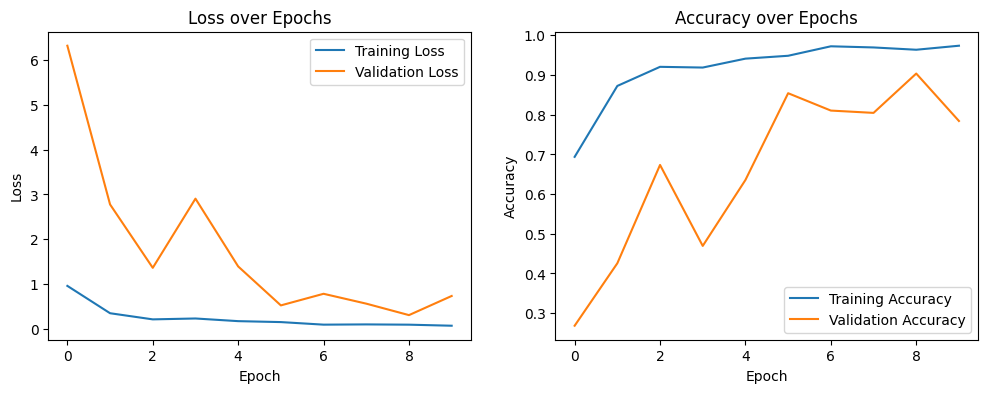

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
loss, accuracy = model.evaluate(test_ds)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.7088 - loss: 1.0145
Test Loss: 0.7512518167495728
Test Accuracy: 0.7799999713897705
